# Group 96

In [1]:
import numpy as np
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from keras.utils import to_categorical

2024-10-26 23:04:18.392414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## extract patches 2d

Reshape a 2D image into a collection of patches of the choosen size.
The resulting patches are allocated in a dedicated array.

## reconstruct from patches 2d

Reconstruct the image from all of its patches.
Patches are assumed to overlap and the image is constructed by filling in the patches from left to right, top to bottom, averaging the overlapping regions.

# Data Importation

In [25]:
# Importing the training patched dataset
Xtrain_a = np.load('Xtrain2_a.npy')
Ytrain_a = np.load('Ytrain2_a.npy')

# Importing the training flattened dataset
Xtrain_b = np.load('Xtrain2_b.npy')
Ytrain_b = np.load('Ytrain2_b.npy')




In [19]:
print(Xtrain_a.shape)
print(Ytrain_a.shape)
print(Xtrain_b.shape)
print(Ytrain_b.shape)

(964908, 49)
(964908,)
(547, 2304)
(547, 2304)


# Data Visualization

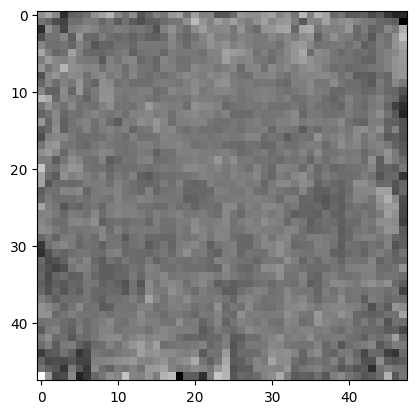

In [140]:
# Size of an image
img_size = [48,48]
# Number of patches for one image
patches = np.array(Xtrain_a[0:1764])

# Reshaping the patches
patches = patches.reshape(-1, 7, 7)
# Reconstructing the image
img_0_a = reconstruct_from_patches_2d(patches = patches, image_size=img_size )

# The image most be reshaped into a 48x48 matrix
img_0_a = img_0_a.reshape(1,48,48)
plt.imshow(img_0_a[0], cmap='gray')
plt.show()


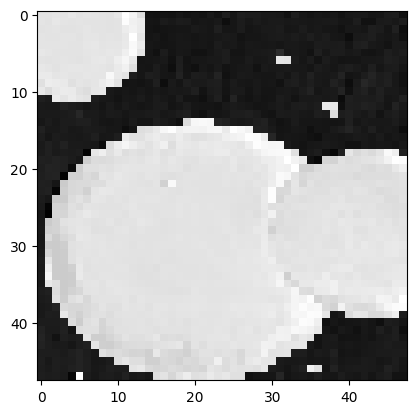

In [141]:
# Each line in the dataset b is a 2D image of 48x48 pixels
Xtrain_b_img = Xtrain_b.reshape(-1, 48, 48)
Ytrain_b_img = Ytrain_b.reshape(-1, 48,48)

# Displaying the first image and the y image
plt.imshow(Xtrain_b_img[0], cmap='gray')
plt.imshow(Ytrain_b_img[0], cmap='gray', alpha=0.8)
plt.show()

In [27]:
Xtrain_a_img = np.zeros((547, 48, 48))
for i in range(0, 547) :
    # Number of patches for one image
    patches = np.array(Xtrain_a[i*1764:(i+1)*1764])
    # Reshaping the patches
    patches = patches.reshape(-1, 7, 7)
    Xtrain_a_img[i] = reconstruct_from_patches_2d(patches = patches, image_size=img_size )

print(np.sum(Xtrain_a_img - Xtrain_b_img))

ValueError: operands could not be broadcast together with shapes (547,48,48) (437,48,48) 

We know that the sets are based on the same images

# Splitting the data

In [26]:
# Only the 110*1764 last patches are used for the validation set
Xval_a = Xtrain_a[len(Xtrain_a)-110*1764:,:]
Yval_a = Ytrain_a[len(Xtrain_a)-110*1764:]
Xtrain_a = Xtrain_a[0:len(Xtrain_a)-110*1764,:]
Ytrain_a = Ytrain_a[0:len(Ytrain_a)-110*1764]

# Only the 110 last images are used for the validation set
Xval_b = Xtrain_b[len(Xtrain_b)-110:,:]
Yval_b = Ytrain_b[len(Xtrain_b)-110:,:]
Xtrain_b = Xtrain_b[0:len(Xtrain_b)-110,:]
Ytrain_b = Ytrain_b[0:len(Ytrain_b)-110,:]

In [27]:
print(Xtrain_a.shape)
print(Ytrain_a.shape)
print(Xval_a.shape)
print(Yval_a.shape)

print(Xtrain_b.shape)
print(Ytrain_b.shape)
print(Xval_b.shape)
print(Yval_b.shape)


(770868, 49)
(770868,)
(194040, 49)
(194040,)
(437, 2304)
(437, 2304)
(110, 2304)
(110, 2304)


# Convolutional Neural : U-NET

## Data processing

In [28]:
# Normalizing the training dataset
Xtrain_a = Xtrain_a/255
Xtrain_b = Xtrain_b/255

# Normalizing the validation dataset
Xval_a = Xval_a/255
Xval_b = Xval_b/255


## Creating the model

In [33]:
def unet_model(input_shape = (48, 48, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encode
    # Convolutions 1 + Reduction
    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Convolutions 2 + Reduction
    c2 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Convolutions 3 + Reduction
    c3 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Convolutions 4 + Reduction
    c4 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(48*2*2*2*2, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(48*2*2*2*2, (3, 3), activation='relu', padding='same')(c5)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u6 = layers.Conv2DTranspose(48*2*2*2, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(48*2*2*2, (3, 3), activation='relu', padding='same')(c6)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u7 = layers.Conv2DTranspose(48*2*2, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(48*2*2, (3, 3), activation='relu', padding='same')(c7)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u8 = layers.Conv2DTranspose(48*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(48*2, (3, 3), activation='relu', padding='same')(c8)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u9 = layers.Conv2DTranspose(48, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c9)

    # Convolution for the output
    outputs = layers.Conv2D(2, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [65]:
# Epochs
epochs = 500
# Batch size
batch_size = 15
# Leraning rate
lr = 0.001

In [66]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr)

# Method to reduce the learning rate when the validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True,verbose = 1)

adam = tf.keras.optimizers.Adam(learning_rate=lr,ema_momentum=0.9)

sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)


## Training the model

In [29]:
Xtrain_b_mat= Xtrain_b.reshape(-1, 48, 48, 1)
Ytrain_b_mat = Ytrain_b.reshape(-1, 48, 48,1)

Xval_b_mat = Xval_b.reshape(-1, 48, 48, 1)
Yval_b_mat = Yval_b.reshape(-1, 48, 48,1)

# Hot encoding the labels
Ytrain_b_mat = to_categorical(Ytrain_b_mat)
Yval_b_mat = to_categorical(Yval_b_mat)

In [ ]:
model_img = unet_model()
model_img.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_img.summary()

history = model_img.fit(Xtrain_b_mat, Ytrain_b_mat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(Xval_b_mat, Yval_b_mat),
                    callbacks=[reduce_lr,early_stopping]
                   )

Best obtained so far -> adam

In [ ]:
# The loss giving the epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# The accuracy giving the epoch
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

# saving the model
model_img.save('/content/drive/MyDrive/MAIN /MAIN 5/S9 /Machine Learning /Classification_Problem_2/model_img.keras')
#weights_img = model_img.weights

## Prédictions


In [69]:
# Charger le modèle et compiler
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('model_img.keras') 

# Prédictions
predictions = model.predict(Xval_b_mat)
# shape of predictions is (109, 48, 48, 2)
# We need to reshape the predictions to (109, 48, 48)
predictions = predictions.argmax(axis=3)

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_254']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step


(110, 48, 48, 1)


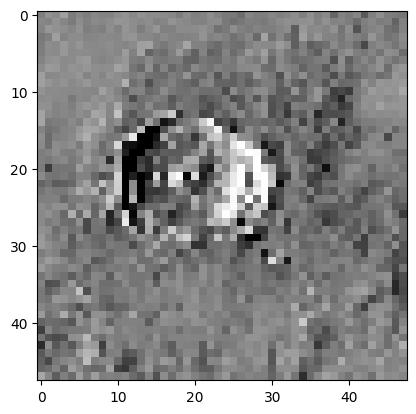

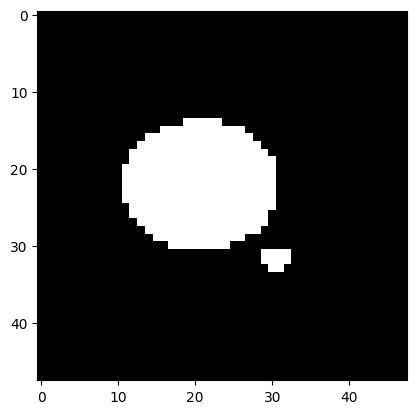

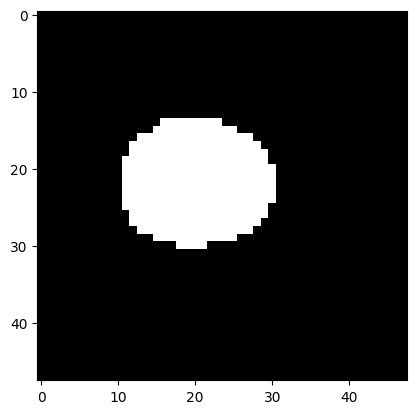

F1_score:  0.6961717723697282


In [70]:
# Hot encoding the predictions
print(predictions.shape)

# Reshaping the predctions
predictions = predictions.reshape(-1, 48, 48)

# Thresholding the predictions
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

# The true image and the predicted one
plt.imshow(Xval_b_mat[3], cmap='gray')
plt.show()
plt.imshow(Yval_b_mat[3], cmap='gray')
plt.show()
plt.imshow(predictions[3], cmap='gray')
plt.show()

# F1_score
f1 = []
for i in range(0,110) :
  f1.append(f1_score(Yval_b_mat[i].flatten(), predictions[i].flatten()))

f1 = np.array(f1)
print("F1_score: ", np.mean(f1))

In [72]:
# Reshaping predictions to have probabilities for each pixel
predictions = predictions.reshape(-1, 48*48)
print(predictions.shape)

(110, 2304)


Best F1_Score : 0.6961717723697282

The model works very well on some images and pretty bad on others

In [30]:
# Balanced accuracy
balanced_accuracy = []
for i in range(0,110) :
  balanced_accuracy.append(balanced_accuracy_score(Yval_b_mat[i].flatten(), predictions[i].flatten()))

balanced_accuracy = np.array(balanced_accuracy)
print("Balanced accuracy: ", np.mean(balanced_accuracy))

Balanced accuracy:  0.8040010856615848


# Model for patches : CNN AlexNet

In [32]:
def alexnet(input_shape=(7, 7, 1)):
    model = models.Sequential()
    
    # Convolution 1
    model.add(layers.Conv2D(49, (3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    # Convolution 2
    model.add(layers.Conv2D(49*2, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Flatten
    model.add(layers.Flatten())
    
    # Fully connected layers
    model.add(layers.Dense(49*4, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization
    
    model.add(layers.Dense(49*2, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(2, activation='sigmoid'))
    
    return model

In [ ]:
# Epochs
epochs = 300
# Batch size
batch_size = 15000
# Leraning rate
lr = 0.001

rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr)

# Method to reduce the learning rate when the validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True,verbose = 1)

adam = tf.keras.optimizers.Adam(learning_rate=lr,ema_momentum=0.9)

sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

# Initialize and compile the model
model = alexnet()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

## Training

In [30]:
# Reshaping Xtrain_a
Xtrain_a_2 = Xtrain_a.reshape(-1, 7, 7, 1)
Xval_a_2 = Xval_a.reshape(-1, 7, 7, 1)

# Hot Encoding the labels
Ytraina_labels = to_categorical(Ytrain_a,2)
Yvala_labels = to_categorical(Yval_a,2)

In [ ]:

# Entrainement
history = model.fit(Xtrain_a_2, Ytraina_labels, epochs=epochs, batch_size=batch_size, validation_data=(Xval_a_2, Yvala_labels), callbacks=[early_stopping])

In [ ]:
# The loss giving the epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# The accuracy giving the epoch
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

# saving the model
#model.save('model_patchs.keras')

## Predictions

In [ ]:
model = alexnet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('model_patchs.keras') 

# Predictions
predictions = model.predict(Xval_a_2)
predictions = np.argmax(predictions, axis=1)

## Score

In [ ]:
balanced_accuracy = balanced_accuracy_score(Yval_a,predictions)
print(balanced_accuracy)

# Combining the models's predictions

In [34]:
# Combinining the two models
# Model 1
model_img = unet_model()
model_img.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_img.load_weights('model_img.keras')

# Model 2
model_patch = alexnet()
model_patch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_patch.load_weights('model_patchs.keras')

# Predictions
predictions_img = model_img.predict(Xval_b_mat)

# Predictions
predictions_patchs = model_patch.predict(Xval_a_2)

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 907ms/step
6064/6064 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step


In [83]:
# The patches from Xval_a 
predictions_patchs_from_img = np.empty((0, 7, 7, 2))

for i in range(0, 110):
    predictions_patchs_from_img = np.concatenate((predictions_patchs_from_img, extract_patches_2d(predictions_img[i], (7, 7))), axis=0)

print(predictions_patchs_from_img.shape)
print(predictions_patchs.shape)


for i in range(0,predictions_patchs.shape[0]):
    for j in range(0, 7):
        for k in range(0,7):
            if (predictions_patchs_from_img[i,j,k,0] < 0.6 and predictions_patchs_from_img[i,j,k,1] > 0.4) or (predictions_patchs_from_img[i,j,k,0] > 0.4 and predictions_patchs_from_img[i,j,k,1] < 0.6) :
                if (predictions_patchs[i,0] > 0.8 and predictions_patchs[i,1] < 0.2) or (predictions_patchs[i,0] < 0.2 and predictions_patchs[i,1] > 0.8) :
                    predictions_patchs_from_img[i,j,k,:] = predictions_patchs[i,:]
                else :
                    predictions_patchs_from_img[i,j,k,:] += 0.5*predictions_patchs[i,:]
                    predictions_patchs_from_img[i,j,k,:] = predictions_patchs_from_img[i,j,k,:]/2
            else :
                continue
                    

print(predictions_patchs_from_img.shape)

(194040, 7, 7, 2)
(194040, 2)
(194040, 7, 7, 2)


In [84]:

Ypred_combined_a = np.zeros((predictions_patchs_from_img.shape[0],2))
print(Ypred_combined_a.shape)
for i in range(0,predictions_patchs_from_img.shape[0]):
    for j in range(0, 7):
        for k in range(0,7):
           Ypred_combined_a[i] = predictions_patchs_from_img[i,j,k,:] 

print(Ypred_combined_a.shape)
Ypred_combined_a = np.argmax(Ypred_combined_a, axis=1)

# Scoring 
prediction_combined = predictions_patchs_from_img

print("Balanced accuracy: ", balanced_accuracy_score(Yval_a, Ypred_combined_a))


(194040, 2)
(194040, 2)
Balanced accuracy:  0.7144872129379012


# Model for patches : Random Forest

## RandomSearch

In [5]:
# Random Search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 300)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

In [49]:


# Training the model
rf_random.fit(Xtrain_a, Ytrain_a)
rf.score(Xval_a, Yval_a)


0.765475536578541

# SVM

In [ ]:
# SVM
svm = SVC(kernel='poly', probability=True, random_state=42,verbose=1)
svm.fit(Xtrain_a, Ytrain_a)

[LibSVM]..............................................................................................................................................................................................................................

In [ ]:
import joblib

# Sauvegarde du modèle dans un fichier
joblib.dump(svm, 'svm_poly.pkl')

In [ ]:
# Draw the boundary
predictions_svm = svm.predict_proba(Xval_a)
balanced_accuracy_svm = balanced_accuracy_score(Yval_a, predictions_svm)
print("Balanced accuracy: ", balanced_accuracy_svm)

In [ ]:
for i in range(0,100):

    svm.fit(Xtrain_a[i:(i+1)*Xtrain_a.shape[0]//1000], Ytrain_a[i:(1+i)*Xtrain_a.shape[0]//1000])
    svm.fit(Xtrain_a,Ytrain_a)

In [29]:



indexes_0 = np.where(Ytrain_a==0)
# Choose randomly 500 samples of each class
indexes_0_500 = np.random.choice(indexes_0[0], 5000)
Ytrain_a_500 = Ytrain_a[indexes_0_500]
Xtrain_a_500 = Xtrain_a[indexes_0_500]


indexes_1 = np.where(Ytrain_a==1)
indexes_1_500 = np.random.choice(indexes_1[0], 5000)
Ytrain_a_500 = np.concatenate((Ytrain_a_500, Ytrain_a[indexes_1_500]))
Xtrain_a_500 = np.concatenate((Xtrain_a_500, Xtrain_a[indexes_1_500]))

# Splitting the dataset a
Xtrain_a_500, Xval_a_500, Ytrain_a_500, Yval_a_500 = train_test_split(Xtrain_a_500, Ytrain_a_500, test_size=0.2, random_state=42)

# Normalizing the training dataset
Xtrain_a_500 = Xtrain_a_500/255


In [32]:
# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42,verbose=1, C=2)
svm.fit(Xtrain_a_500, Ytrain_a_500)

[LibSVM].......*...*
optimization finished, #iter = 10205
obj = -7138.990747, rho = -0.638869
nSV = 5084, nBSV = 3453
Total nSV = 5084
.......*...*
optimization finished, #iter = 10074
obj = -7165.368931, rho = -0.617994
nSV = 5126, nBSV = 3440
Total nSV = 5126
.......*...*
optimization finished, #iter = 10116
obj = -7235.701786, rho = -0.570156
nSV = 5133, nBSV = 3496
Total nSV = 5133
.......*..*
optimization finished, #iter = 9752
obj = -7142.872864, rho = -0.591310
nSV = 5096, nBSV = 3461
Total nSV = 5096
.......*...*
optimization finished, #iter = 10576
obj = -7270.547526, rho = -0.573980
nSV = 5175, nBSV = 3513
Total nSV = 5175
.........*...*
optimization finished, #iter = 12293
obj = -9051.205061, rho = 0.620065
nSV = 6332, nBSV = 4398
Total nSV = 6332


SVC(C=2, probability=True, random_state=42, verbose=1)

In [33]:
pred = svm.predict(Xval_a_500)

#balanced accuracy
balanced_accuracy_svm = balanced_accuracy_score(Yval_a_500, pred)
print("Balanced accuracy: ", balanced_accuracy_svm)

Balanced accuracy:  0.5


# Submission

In [86]:
# Importation of the test dataset
Xtest_b = np.load('Xtest2_b.npy')

# Normalizing the validation dataset
Xtest_b = Xtest_b/255

# Reshaping the test dataset
Xtest_b = Xtest_b.reshape(-1, 48, 48, 1)

# Loading the model
model_img = unet_model()
model_img.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_img.load_weights('model_img.keras')

# Prediction probabilities
Ypred_b = model_img.predict(Xtest_b)



/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_143']. Received: the structure of inputs=*
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step


We predict with the Only the U-net model

In [88]:
# Prediction labels
Ypred_b = np.argmax(Ypred_b, axis=3)

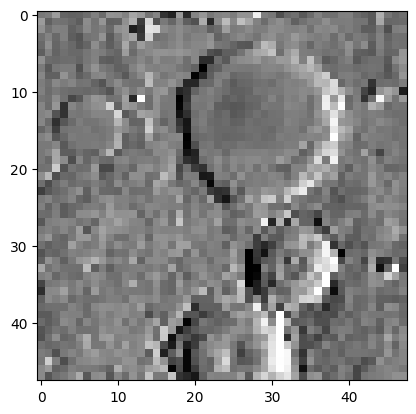

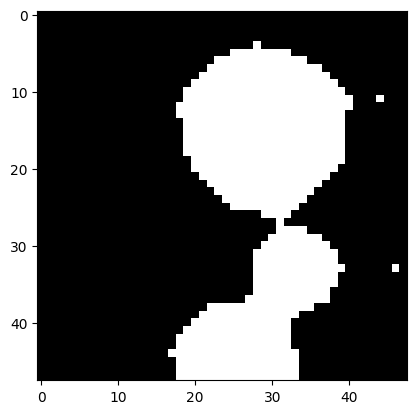

In [104]:
plt.imshow(Xtest_b[9], cmap='gray')
plt.show()
plt.imshow(Ypred_b[9], cmap='gray')
plt.show()

In [107]:
# Importation of the train set
Ytrain_b = np.load('Ytrain2_b.npy')
print(Ytrain_b.shape)

# Reshaping the predictions
Ypred_b = Ypred_b.reshape(-1, 48*48)
print(Ypred_b.shape)

(547, 2304)
(196, 2304)


In [108]:
# Saving the predictions
np.save('Ypred_b.npy', Ypred_b)

plt.imshow()